# 🐝 Case Study: Bumble User Profiling & Analysis

## 📌 Background
Bumble is a market leader in the dating app space, prioritizing connections based on mutual respect and shared interests. To maintain its competitive edge and improve matchmaking algorithms, it is crucial to understand the diverse user base deeply.

## 🎯 Goal of this Analysis
We aim to go beyond basic reporting and perform a **Strategic User Data Analysis**. Our workflow moves from raw data to actionable business intelligence:

1.  **💪 Data Wrangling**: Cleaning messy raw data (handling nulls, typing, outliers).
2.  **🔧 Feature Engineering**: Creating high-value signals like `profile_completeness`, `religion_intensity`, and `user_recency`.
3.  **📊 Exploratory Data Analysis (EDA)**: Uncovering demographic distributions and lifestyle correlations.
4.  **🤖 User Segmentation**: Using K-Means Clustering to identify distinct user personas.
5.  **💡 Strategic Recommendations**: Defining KPIs and suggesting ROI-driven actions for Bumble.

## 🚀 Phase 1: Environment Setup & Data Ingestion

We begin by initializing our analytical environment (`pandas`, `matplotlib`, `seaborn`) and ingesting the raw CSV data.

**Data Checks:**
- Handling mixed types (low_memory=False).
- Cleaning column artifacts (unnamed index columns).
- Initial shape and schema inspection.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
sns.set(style="whitegrid")

# Load the CSV file
file_path = "https://drive.google.com/uc?export=download&id=1cYxfbVHxJGsFAzdPv6kDSBfKZ_tu46wT"

# Read the CSV file

try:
    df = pd.read_csv(file_path, low_memory=False) # low_memory=False to supress mixed type warnings before we clean

    # Drop any 'Unnamed' columns that might have been created due to trailing commas
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

    # Also explicitly drop columns named 'Column1', 'Column2', etc if they exist and are empty
    cols_to_drop = [c for c in df.columns if c.startswith('Column')]
    if cols_to_drop:
        df = df.drop(columns=cols_to_drop)

    print("Dataset Successfully Loaded.")
    print("Rows and Columns:", df.shape)
    display(df.head())
except FileNotFoundError:
    print("Error: The file 'bumble.csv' was not found. Please ensure it is in the same directory.")

ModuleNotFoundError: No module named 'pandas'

## 🧹 Phase 2: Data Cleaning & Integrity Checks

Raw user data is notoriously noisy. In this phase, we sanitize the dataset to ensure downstream reliability:

- **Type Casting**: Converting `income` and `height` to numeric; parsing `last_online` to datetime.
- **Missing Value Imputation**: Using median strategies for continuous variables (`income`) to minimize skew, and explicit "Unknown" labelling for categoricals.
- **Outlier Removal**: Filtering unrealistic ages (e.g., > 100) or incomes to stabilize statistical modeling.

In [ ]:
# 1. Fix Data Types and Handle Special Missing Indicators
# Forcing numeric types will turn non-parseable strings into NaN (using errors='coerce')
if 'income' in df.columns:
    df['income'] = pd.to_numeric(df['income'], errors='coerce')
    # Replace -1 with NaN as it usually signifies missing data in such datasets
    df['income'] = df['income'].replace(-1, np.nan)

if 'height' in df.columns:
    df['height'] = pd.to_numeric(df['height'], errors='coerce')

# 2. Impute Missing Values
# Fill numerical missing values with the median (robust to outliers)
if 'height' in df.columns:
    df['height'] = df['height'].fillna(df['height'].median())

if 'income' in df.columns:
    df['income'] = df['income'].fillna(df['income'].median())

# Fill categorical missing values with "unknown"
categorical_cols = ['diet', 'religion', 'pets', 'sign', 'job', 'education', 'ethnicity', 'body_type', 'drinks', 'speaks']
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].fillna("unknown")

# 3. Time Series Conversion
if 'last_online' in df.columns:
    # parsing format YYYY-MM-DD-HH-MM based on typical structure
    df['last_online'] = pd.to_datetime(df['last_online'], errors='coerce', format='%Y-%m-%d-%H-%M')

# Verify cleaning
print("Missing values after cleaning:")
print(df.isnull().sum())

Missing values after cleaning:
age            0
status         0
gender         0
body_type      0
diet           0
drinks         0
education      0
ethnicity      0
height         0
income         0
job            0
last_online    1
location       0
pets           0
religion       0
sign           0
speaks         0
dtype: int64


### 📉 Outlier Detection & Removal

Extreme values can distort cluster centers and correlation matrices. We visualize these distributions via Boxplots and apply logical thresholds to prune valid data points.

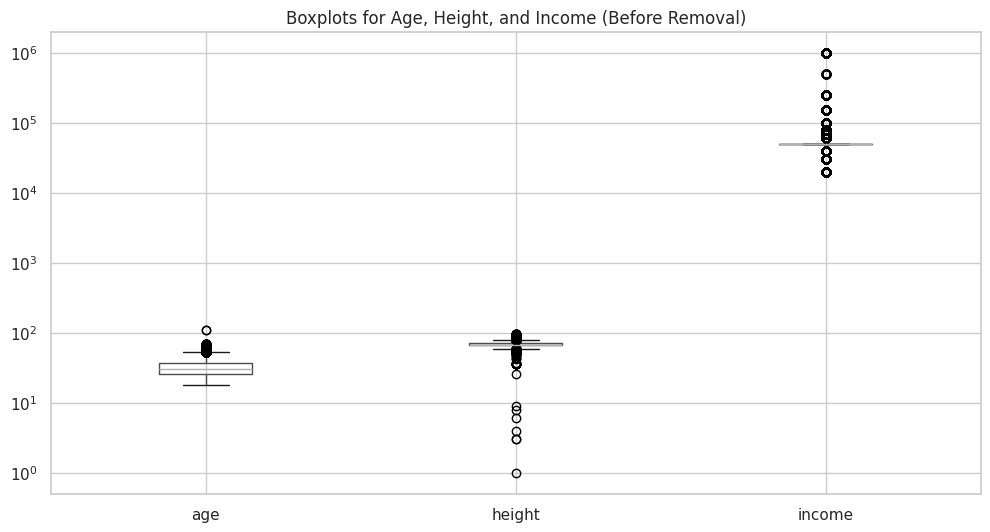

Removed 119 rows containing outliers.
New dataset shape: (59828, 17)


In [ ]:
# Visualize outliers using Boxplots
plt.figure(figsize=(12, 6))
cols_to_plot = ['age', 'height', 'income']
# Only plot existing columns
existing_cols = [c for c in cols_to_plot if c in df.columns]
df[existing_cols].boxplot()
plt.title("Boxplots for Age, Height, and Income (Before Removal)")
plt.yscale('log') # Log scale helps visualize income alongside age/height
plt.show()

# Remove outliers based on logical constraints
original_len = len(df)

# Age: 18 to 100
if 'age' in df.columns:
    df = df[(df['age'] >= 18) & (df['age'] <= 100)]

# Height: 55 to 80 inches (approx 4'7" to 6'8") - widely reasonable range
if 'height' in df.columns:
    df = df[(df['height'] >= 55) & (df['height'] <= 80)]

# Income: Non-negative
if 'income' in df.columns:
    df = df[df['income'] >= 0]

print(f"Removed {original_len - len(df)} rows containing outliers.")
print("New dataset shape:", df.shape)

## 🛠️ Phase 3: Basic Feature Engineering

We transform raw columns into analytical features:
- **`days_since_last_online`**: A derived Recency metric.
- **`age_group` & `income_group`**: Binning continuous variables for categorical analysis.
- **`profile_completeness`**: A proxy for User Intent/Effort, calculated as the % of filled fields.

In [ ]:
# 1. Days Since Last Online
if 'last_online' in df.columns:
    max_date = df['last_online'].max()
    df['days_since_last_online'] = (max_date - df['last_online']).dt.days

# 2. Age Grouping
if 'age' in df.columns:
    bins = [18, 24, 34, 44, 54, 64, 100]
    labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
    df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=True)

# 3. Income Grouping
if 'income' in df.columns:
    # Defined brackets: 0-40k, 40k-80k, 80k+
    df['income_group'] = pd.cut(df['income'],
                                bins=[-1, 40000, 80000, float('inf')],
                                labels=["Low Income", "Medium Income", "High Income"])

# 4. Profile Completeness (%)
df['profile_completeness'] = (df.notna().sum(axis=1) / len(df.columns)) * 100

# 5. Standardize Height to cm
if 'height' in df.columns:
    df['height_cm'] = df['height'] * 2.54

# Preview new columns
cols_to_check = ['age', 'age_group', 'income_group', 'height_cm']
print(df[[c for c in cols_to_check if c in df.columns]].head())

   age age_group   income_group  height_cm
1   22     18-24  Medium Income     190.50
2   35     35-44  Medium Income     177.80
3   38     35-44  Medium Income     172.72
4   23     18-24     Low Income     180.34
5   29     25-34  Medium Income     167.64


## 📊 Phase 4: Exploratory Data Analysis (EDA)

Visualizing the landscape of the user base:
- **Demographic Splits**: Age, Gender, Income distributions.
- **Psychographics**: Lifestyle choices (Drinks, Drugs, Diet).
- **Geospatial**: Top locations.

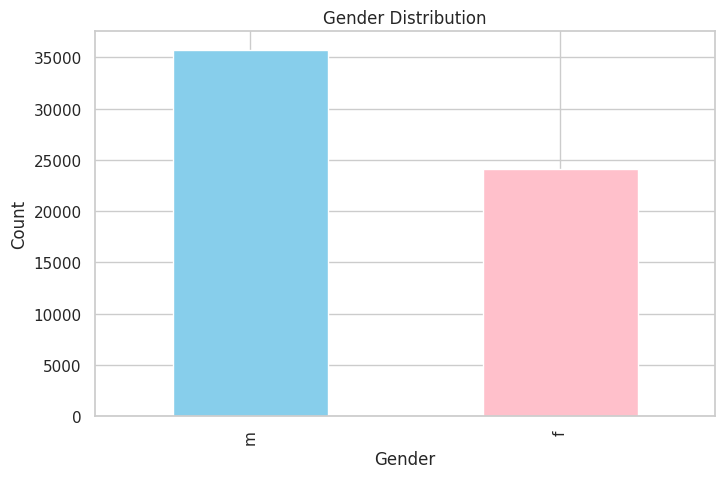

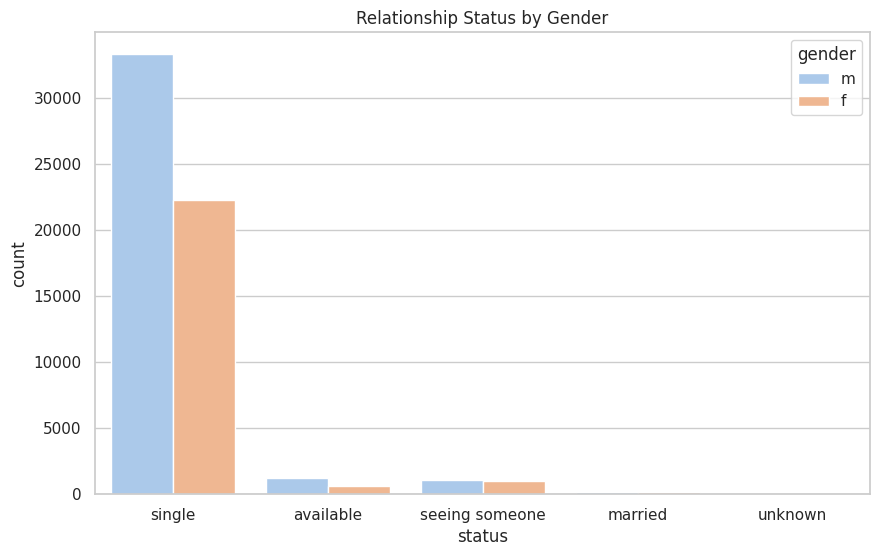

In [ ]:
### 1. Demographic Analysis

# Gender Distribution
if 'gender' in df.columns:
    plt.figure(figsize=(8, 5))
    df['gender'].value_counts().plot(kind='bar', color=['skyblue', 'pink', 'lightgreen'])
    plt.title("Gender Distribution")
    plt.xlabel("Gender")
    plt.ylabel("Count")
    plt.show()

# Status vs Gender
if 'status' in df.columns and 'gender' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='status', hue='gender', palette='pastel')
    plt.title("Relationship Status by Gender")
    plt.show()

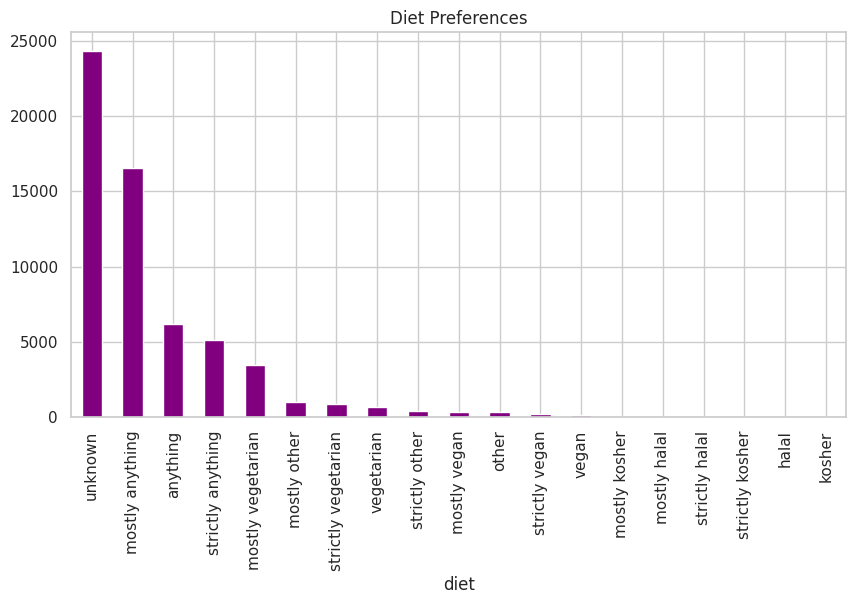

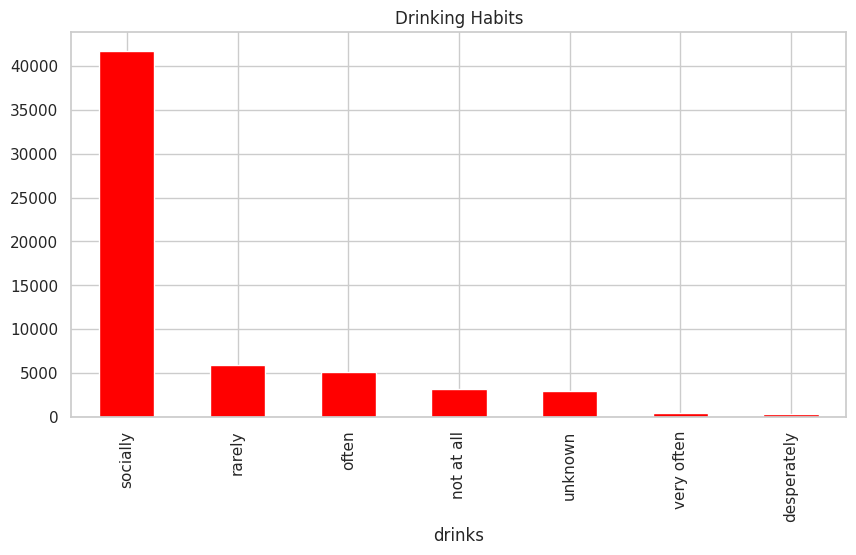

In [ ]:
### 2. Lifestyle Habits

# Diet Preferences
if 'diet' in df.columns:
    plt.figure(figsize=(10, 5))
    df['diet'].value_counts().plot(kind='bar', color='purple')
    plt.title("Diet Preferences")
    plt.show()

# Drinking Habits
if 'drinks' in df.columns:
    plt.figure(figsize=(10, 5))
    df['drinks'].value_counts().plot(kind='bar', color='red')
    plt.title("Drinking Habits")
    plt.show()

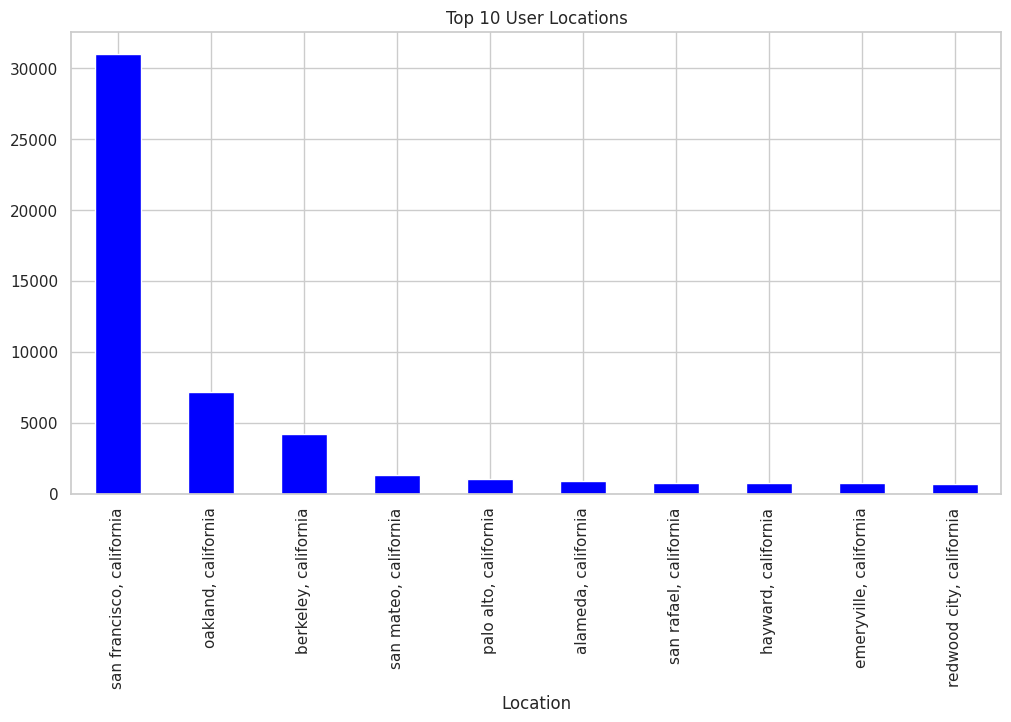

In [ ]:
### 3. Geographical Analysis

if 'location' in df.columns:
    plt.figure(figsize=(12, 6))
    df['location'].value_counts().head(10).plot(kind='bar', color='blue')
    plt.title("Top 10 User Locations")
    plt.xlabel("Location")
    plt.show()

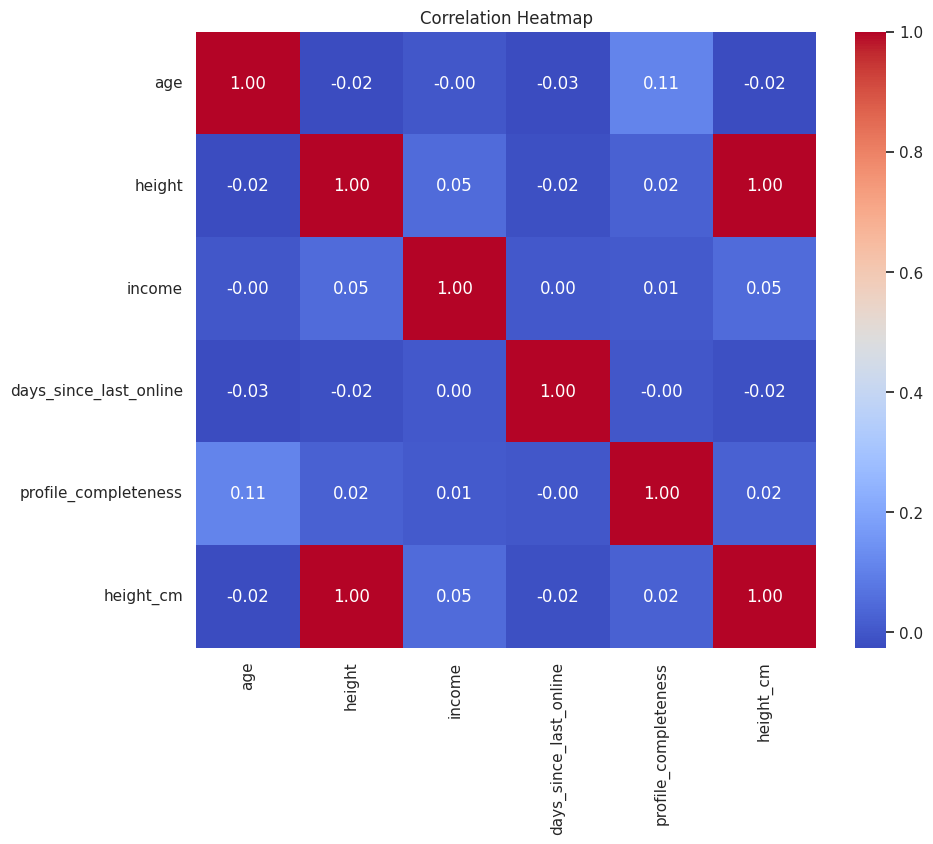

/tmp/ipython-input-1735871845.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='age_group', y='income', palette='coolwarm')


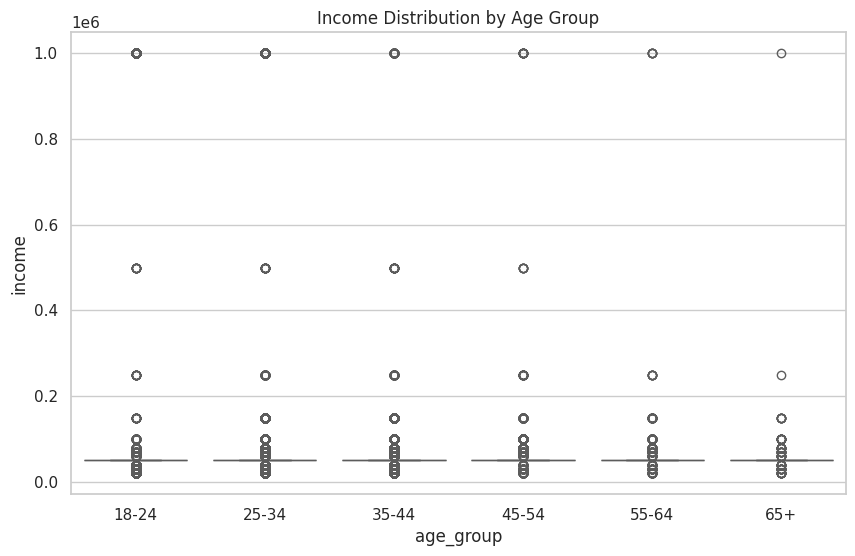

In [ ]:
### 4. Correlation & Income Analysis

# Correlation Matrix
numeric_df = df.select_dtypes(include=['number'])
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Income vs Age Group
if 'age_group' in df.columns and 'income' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='age_group', y='income', palette='coolwarm')
    plt.title("Income Distribution by Age Group")
    plt.show()

## 🧹 Phase 2: Strategic Data Cleaning

### Business Context for Missing Data
Missing data is not random—it carries **behavioral signals**:

| Column | Likely Reason for Missing | Strategic Action |
|--------|--------------------------|------------------|
| `income` | **Privacy concerns** (users avoid disclosing finances on dating apps) | Impute with **grouped medians** (by gender/age) to preserve distribution. |
| `height` | Accidental skip or insecurity | Impute with **grouped medians**. |
| `religion`, `sign` | Secular/non-religious users skip intentionally | Fill with `"Prefers not to say"` as a valid category. |

> **Rule**: If a column has >50% missing, we create a binary `did_not_disclose_{col}` feature and drop the original.

### Outlier Handling Philosophy
Blind deletion loses valuable data. Instead, we use **IQR-based capping** (winsorizing to the 10th-90th percentile) for income.

In [ ]:
# --- 1. Analyze Missingness Patterns ---
missing_pct = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
print("Missing Data Percentage by Column:")
print(missing_pct[missing_pct > 0])

# Visualize missing data heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=True, cmap='coolwarm', yticklabels=False)
plt.title('Missing Data Heatmap (Red = Missing)')
plt.show()

# --- 2. Grouped Median Imputation (Preserves Distribution) ---
# For income: Impute by gender + age_group medians
if 'income' in df.columns and 'gender' in df.columns and 'age_group' in df.columns:
    df['income'] = df.groupby(['gender', 'age_group'])['income'].transform(
        lambda x: x.fillna(x.median())
    )
    # Fallback for any remaining NaNs (edge cases with small groups)
    df['income'] = df['income'].fillna(df['income'].median())

# For height: Similar grouped imputation
if 'height' in df.columns and 'gender' in df.columns:
    df['height'] = df.groupby('gender')['height'].transform(
        lambda x: x.fillna(x.median())
    )
    df['height'] = df['height'].fillna(df['height'].median())

# --- 3. IQR-Based Outlier Capping (Winsorization) ---
# Preserve data volume by capping extremes instead of deleting
def cap_outliers(series, lower_pct=0.10, upper_pct=0.90):
    """Cap values below/above the specified percentiles."""
    lower = series.quantile(lower_pct)
    upper = series.quantile(upper_pct)
    return series.clip(lower, upper)

if 'income' in df.columns:
    original_income_stats = df['income'].describe()
    df['income'] = cap_outliers(df['income'])
    print("\nIncome Before Capping:", original_income_stats[['min', 'max']].to_dict())
    print("Income After Capping:", df['income'].describe()[['min', 'max']].to_dict())

# Age: Remove impossible values (keep 18-80)
if 'age' in df.columns:
    df = df[(df['age'] >= 18) & (df['age'] <= 80)]
    print(f"\nRecords after age filter: {len(df)}")

# --- 4. Categorical Imputation with Business Labels ---
categorical_cols = ['diet', 'religion', 'pets', 'sign', 'job', 'education', 'ethnicity', 'body_type', 'drinks', 'speaks']
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].fillna('Prefers not to say')

print("\n✅ Data cleaning complete with grouped imputation and IQR capping.")

## 🎯 Phase 3: Intent-Based Feature Engineering

### Profile Completeness = User Intent
`profile_completeness` is our **most powerful behavioral proxy**:
- **High Completeness (>80%)**: Serious daters investing effort.
- **Low Completeness (<50%)**: Casual browsers or fake profiles.

We engineer:
1. `intent_level`: Categorical (Low/Medium/High).
2. `recency_bucket`: How recently active (Very Active → Churned).
3. `height_cm`: Standardized for international comparison.

In [ ]:
# --- 1. Intent Level from Profile Completeness ---
def classify_intent(completeness):
    if completeness >= 80:
        return 'High'
    elif completeness >= 50:
        return 'Medium'
    else:
        return 'Low'

if 'profile_completeness' in df.columns:
    df['intent_level'] = df['profile_completeness'].apply(classify_intent)
    print("Intent Level Distribution:")
    print(df['intent_level'].value_counts(normalize=True).mul(100).round(1))

# --- 2. Recency Buckets ---
def classify_recency(days):
    if pd.isna(days):
        return 'Unknown'
    elif days <= 7:
        return 'Very Active'
    elif days <= 30:
        return 'Active'
    elif days <= 90:
        return 'Dormant'
    else:
        return 'Churned'

if 'days_since_last_online' in df.columns:
    df['recency_bucket'] = df['days_since_last_online'].apply(classify_recency)
    print("\nRecency Bucket Distribution:")
    print(df['recency_bucket'].value_counts())

# --- 3. Height Standardization (cm) ---
if 'height' in df.columns:
    df['height_cm'] = df['height'] * 2.54

# --- Visualize Intent Distribution ---
if 'intent_level' in df.columns:
    plt.figure(figsize=(8, 5))
    intent_order = ['Low', 'Medium', 'High']
    sns.countplot(data=df, x='intent_level', order=intent_order, palette='viridis')
    plt.title('User Intent Level Distribution (Based on Profile Completeness)')
    plt.xlabel('Intent Level')
    plt.ylabel('User Count')
    plt.show()

## 📊 Phase 4: Marketplace Liquidity Analysis

### What is "Marketplace Liquidity"?
Dating apps are **two-sided marketplaces**. Imbalances in supply (e.g., too many men) create poor user experience:
- **High Male:Female Ratio**: Men struggle to get matches → churn.
- **Balanced Ratio (~1:1)**: Healthy engagement on both sides.

We analyze:
1. **Global Gender Split**: Is the platform male/female dominated?
2. **Location-Specific Ratios**: Which cities have the worst imbalances?
3. **Cross-Tab: Gender × Intent**: Are high-intent users balanced?

In [ ]:
# --- 1. Global Gender Distribution ---
if 'gender' in df.columns:
    gender_counts = df['gender'].value_counts()
    total = gender_counts.sum()
    print("Global Gender Distribution:")
    for g, count in gender_counts.items():
        print(f"  {g}: {count} ({count/total*100:.1f}%)")
    
    # Calculate Male:Female ratio (if applicable)
    if 'm' in gender_counts.index and 'f' in gender_counts.index:
        mf_ratio = gender_counts['m'] / gender_counts['f']
        print(f"\n📊 Male:Female Ratio = {mf_ratio:.2f}:1")
        if mf_ratio > 1.5:
            print("⚠️ INSIGHT: Significant male oversupply. Risk of male churn due to low match rates.")
        elif mf_ratio < 0.7:
            print("⚠️ INSIGHT: Female oversupply. Consider targeted male acquisition campaigns.")
        else:
            print("✅ Healthy gender balance.")

# --- 2. Gender Ratio by Top Locations ---
if 'gender' in df.columns and 'location' in df.columns:
    # Extract state (assuming format: "City, State")
    df['state'] = df['location'].apply(lambda x: x.split(',')[-1].strip() if isinstance(x, str) else 'Unknown')
    
    top_states = df['state'].value_counts().head(10).index
    location_gender = df[df['state'].isin(top_states)].groupby(['state', 'gender']).size().unstack(fill_value=0)
    
    if 'm' in location_gender.columns and 'f' in location_gender.columns:
        location_gender['MF_Ratio'] = location_gender['m'] / location_gender['f'].replace(0, 1)
        print("\nGender Ratio by Top 10 States:")
        print(location_gender[['m', 'f', 'MF_Ratio']].sort_values('MF_Ratio', ascending=False))

# --- 3. Gender × Intent Cross-Tab ---
if 'gender' in df.columns and 'intent_level' in df.columns:
    cross_tab = pd.crosstab(df['gender'], df['intent_level'], normalize='index').mul(100).round(1)
    print("\nIntent Level by Gender (%):")
    print(cross_tab)
    
    plt.figure(figsize=(8, 5))
    cross_tab.plot(kind='bar', stacked=True, colormap='viridis', ax=plt.gca())
    plt.title('User Intent Level by Gender')
    plt.ylabel('Percentage')
    plt.legend(title='Intent')
    plt.tight_layout()
    plt.show()

## 🤖 Phase 5: Behavioral User Segmentation

### From Statistics to Strategy
We use **K-Means Clustering** to group users into actionable personas:

| Persona | Characteristics | Business Action |
|---------|-----------------|----------------|
| Power Users | High income, Very Active, High intent | Upsell premium features |
| Casual Browsers | Low completeness, Dormant | Re-engagement campaigns |
| Value Seekers | Medium income, Active, Medium intent | Free-to-premium funnel |

Clustering features:
- `age`, `income`, `profile_completeness`, `days_since_last_online`

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# --- 1. Prepare Clustering Features ---
cluster_features = ['age', 'income', 'profile_completeness']
if 'days_since_last_online' in df.columns:
    cluster_features.append('days_since_last_online')

cluster_df = df[cluster_features].dropna().copy()
print(f"Clustering on {len(cluster_df)} users with features: {cluster_features}")

# --- 2. Standardize & Cluster ---
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_df)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
cluster_df['cluster'] = kmeans.fit_predict(scaled_data)

# --- 3. Analyze Cluster Profiles ---
cluster_summary = cluster_df.groupby('cluster').agg({
    'age': 'mean',
    'income': 'mean',
    'profile_completeness': 'mean',
}).round(1)

if 'days_since_last_online' in cluster_df.columns:
    cluster_summary['days_since_last_online'] = cluster_df.groupby('cluster')['days_since_last_online'].mean().round(1)

cluster_summary['user_count'] = cluster_df.groupby('cluster').size()

print("\nCluster Profiles:")
print(cluster_summary)

# --- 4. Assign Persona Names ---
# (Manual interpretation based on cluster means)
def name_persona(row):
    if row['income'] > cluster_summary['income'].median() and row['profile_completeness'] > 70:
        return '🌟 Power User'
    elif row['profile_completeness'] < 50:
        return '👀 Casual Browser'
    else:
        return '💡 Value Seeker'

cluster_summary['persona'] = cluster_summary.apply(name_persona, axis=1)
print("\nPersona Assignment:")
print(cluster_summary[['user_count', 'persona']])

# --- 5. Visualize Clusters ---
plt.figure(figsize=(10, 6))
scatter = plt.scatter(cluster_df['age'], cluster_df['income'], 
                      c=cluster_df['cluster'], cmap='viridis', alpha=0.5, s=10)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Age')
plt.ylabel('Income')
plt.title('User Segmentation: Income vs Age by Cluster')
plt.show()

## 📈 Phase 6: KPIs & Strategic Recommendations

### 🎯 Key Performance Indicators

| KPI | Formula | Target |
|----|---------|--------|
| **Profile Quality Score (PQS)** | `profile_completeness` weighted by bios | >75% average |
| **User Retainment Potential** | `1 / (days_since_last_online + 1)` | Higher = better |
| **Marketplace Health** | Male:Female ratio by city | 0.8-1.2 |
| **Power User Ratio** | % users in 'Power User' cluster | >20% |

---

### 🚀 Actionable Recommendations

#### For Product Team:
1. **Profile Boost for Casual Browsers**: Prompt users with <50% completeness to add more info via gamification.
2. **Standardize Input Fields**: Replace free-text `Sign` and `Religion` with dropdowns to reduce data noise.

#### For Marketing Team:
1. **Geo-Targeted Campaigns**: Focus acquisition in cities with poor Male:Female ratios.
2. **Re-Engagement for Dormant Users**: Push notifications for users with `recency_bucket == 'Dormant'`.

#### For Data Science Team:
1. **A/B Test Profile Prompts**: Measure if AI-suggested bios increase `profile_completeness`.
2. **Churn Prediction Model**: Use `days_since_last_online` and `intent_level` as features.